# Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Data

In [9]:
path = "/content/drive/MyDrive/Projects/Telco_Churn"

In [10]:
data = pd.read_csv(path + "/Data/telco_processed.csv",index_col=0)  

In [11]:
data.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State
0,0.676489,1.234883,1.566767,-0.070610,0.866743,-0.085008,-0.427932,0,0,1,0.476643,1.567036,-0.055940,-0.070427,-0.465494,0.866029,-0.601195,-0.085690,0
1,0.149065,1.307948,-0.333738,-0.108080,1.058571,1.240482,-0.427932,0,0,1,1.124503,-0.334013,0.144867,-0.107549,0.147825,1.059390,-0.601195,1.241169,0
2,0.902529,-0.591760,1.168304,-1.573383,-0.756869,0.703121,-1.188218,0,0,0,0.675985,1.168464,0.496279,-1.573900,0.198935,-0.755571,0.211534,0.697156,1
3,-0.428590,-0.591760,2.196596,-2.742865,-0.078551,-1.303026,0.332354,0,1,0,-1.466936,2.196759,-0.608159,-2.743268,-0.567714,-0.078806,1.024263,-1.306401,0
4,-0.654629,-0.591760,-0.240090,-1.038932,-0.276311,-0.049184,1.092641,0,1,0,0.626149,-0.240041,1.098699,-1.037939,1.067803,-0.276562,-0.601195,-0.045885,0


In [12]:
target = 'Churn'
features = data.columns.drop("Churn")

In [13]:
X = data[features]
y = data[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
for df in [X_train,X_test]:
  print(df.shape)

(2333, 18)
(1000, 18)


# Random Forest

## Default Parameters

In [21]:
def get_AUC(model):
  y_pred_prob = model.predict_proba(X_test)[:, 1]
  print(roc_auc_score(y_test, y_pred_prob))

In [52]:
clf = RandomForestClassifier(random_state = 20200226)
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=20200226)

In [53]:
# Print the AUC
get_AUC(clf)

0.9126053704013845


# Model Tuning

**Test different determinants of max_features**

In [55]:
# Create the hyperparameter grid
param_grid = {'max_features': ['auto', 'sqrt', 'log2']}
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=20200226),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']})

In [56]:
# Print the optimal parameters
print(grid_search.best_params_)

{'max_features': 'auto'}


In [57]:
get_AUC(grid_search)

0.9126053704013845


So the default performs best

**Expand the hyperparameter search**

In [59]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10, 'auto'],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=20200226),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, None],
                         'max_features': [1, 3, 10, 'auto']})

In [60]:
print(grid_search.best_params_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10}


# Final Model Evaluation

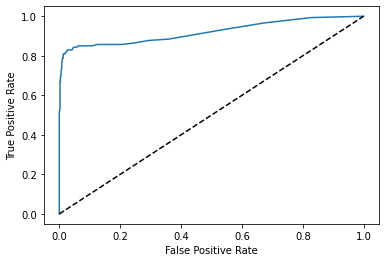

In [61]:
y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [62]:
# Print the AUC
print(roc_auc_score(y_test, y_pred_prob))

0.9203890231356319


# Feature Importances

In [63]:
clf = grid_search.best_estimator_
importances = clf.feature_importances_

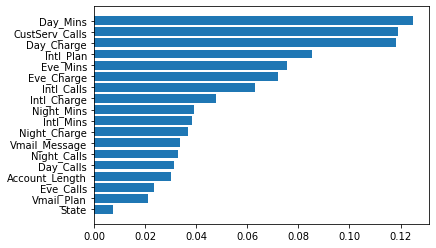

In [64]:
# Sort importances
sorted_index = np.argsort(importances)

# Create labels
labels = X.columns[sorted_index]

# Clear current plot
plt.clf()

# Create plot
plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()